In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Value gradient method
Here we use value gradients to solve simple control problems.
$$
\begin{array}{ll}
V_{\theta}^t = r_a^t \pi_{\theta}^t + \gamma V_s^{t+1} f_a^t \pi_{\theta}^t + \gamma V_{\theta}^{t+1} \\
V_s^t = r_s^t + r_a^t \pi_s^t+ \gamma V_s^{t+1} (f_s^t + f_a^t \pi_s^t)
\end{array}
$$

In [2]:
def compute_policy_gradient(env,policy,path,gamma):
    T = len(path["rewards"])
    n = len(path["observations"][0])
    D = len(policy.get_theta())
    V_theta = np.zeros((T,D))
    V_s = np.zeros((T,n))
    
    for t in range(T-2,-1,-1):
        s = path["observations"][t]
        a = path["actions"][t]
        s2 = path["observations"][t+1]
        r_a = env.r_a(s,a)
        r_s = env.r_s(s,a)
        f_s = env.f_s(s,a)
        f_a = env.f_a(s,a)
        pi_theta = policy.pi_theta(s)
        pi_s = policy.pi_s(s)
        
        V_s[t] = r_s + r_a.dot(pi_s) + gamma * V_s[t+1].dot(f_s + f_a.dot(pi_s))
        V_theta[t] = r_a.dot(pi_theta) + gamma * V_s[t+1].dot(f_a.dot(pi_theta)) + gamma * V_theta[t+1]
    return V_s,V_theta

## Point MDP
$$r(s,a) = -\frac{1}{2}(\|s+a\|_2^2)$$
$$r_s(s,a) = -(s+a),\quad r_a(s,a) = -(s+a)$$
$$f(s,a) = s + a $$
$$f_s(s,a) = I_2,\quad f_a(s,a) = I_2 $$
Terminate when $$ \|s\|_2 < 0.01$$

In [3]:
class PointEnvLinearPolicy(object):
    def __init__(self,dim=2):
        self.state_dim = dim
        self.G = np.random.normal(size=(dim,dim))
    def get_action(self,state):
        action = self.G.dot(state)
        return action
    
    def get_theta(self):
        return policy.G.reshape((-1,))
    
    def set_theta(self,value):
        self.G = np.reshape(value,self.G.shape)
    
    def pi_theta(self,state):
        n = self.state_dim
        J = np.zeros((n, n**2))
        for i in range(n):
            J[i,i*n:(i+1)*n] = state
        return J
    
    def pi_s(self,state):
        return self.G

In [4]:
import lasagne.layers as L
import lasagne.nonlinearities as NL
import theano
import theano.tensor as T
from rllab.core.network import MLP
from rllab.core.lasagne_powered import LasagnePowered
from rllab.core.serializable import Serializable
from rllab.misc import ext

class DeterministicMLPPolicy(LasagnePowered,Serializable):
    def __init__(
            self,
            env_spec,
            hidden_sizes=[32,32],
            hidden_nonlinearity=NL.tanh,
        ):
        # constrain the output actions by tanh and linear rescaling
        act_bounds = env_spec.action_space.bounds
        ll = np.array(act_bounds)[0]
        uu = np.array(act_bounds)[1]
        aa = (uu-ll)/2
        bb = (uu+ll)/2
        def output_constrain(x):
            return T.tanh(x) * aa + bb
        
        # construct the network
        obs_dim = env_spec.observation_space.flat_dim
        act_dim = env_spec.action_space.flat_dim
        network = MLP(
            input_shape=(obs_dim,),
            output_dim=act_dim,
            hidden_sizes=hidden_sizes,
            hidden_nonlinearity=hidden_nonlinearity,
            output_nonlinearity=output_constrain,
        )
        l_out = network.output_layer
        act_var = L.get_output(l_out).flatten()
        obs_var = network.input_layer.input_var
        
        # output
        LasagnePowered.__init__(self, [l_out])
        self._get_action = ext.compile_function(
            inputs=[obs_var],
            outputs=act_var,
        )
        
        # derivatives
        theta = self.get_params()
        flat_grads = []
        for i in range(act_dim):
            # grad w.r.t. NN params are grouped by layers; so need to flatten
            grad = theano.grad(act_var[i], wrt=theta, disconnected_inputs='warn')
            flat_grad = ext.flatten_tensor_variables(grad) 
            flat_grads.append(flat_grad)
        jacobian_theta = T.stack(flat_grads)
        self._pi_theta = ext.compile_function(
            inputs=[obs_var],
            outputs=jacobian_theta,
        )
        
        flat_grads = []
        for i in range(act_dim):
            # beware of the final ravel()
            grad = theano.grad(act_var[i], wrt=obs_var, disconnected_inputs='warn').ravel()
            flat_grads.append(grad)
        jacobian_s = T.stack(flat_grads)
        self._pi_s = ext.compile_function(
            inputs=[obs_var],
            outputs=jacobian_s,
        )
        
    def get_action(self,state):
        agent_info = dict()
        action = self._get_action([state])
        return action, agent_info
        
    def get_theta(self):
        return self.get_param_values()
        
    def set_theta(self,value):
        self.set_param_values(value)
        
    def pi_theta(self,state):
        return self._pi_theta([state])
    
    def pi_s(self,state):
        return self._pi_s([state])
    
    def reset(self):
        pass

In [5]:
from rllab.sampler.utils import rollout
def train(env,policy,n_iter,horizon,lr,gamma):
    paths = []
    for i in range(n_iter):
        # simulate
        path = rollout(env,policy,horizon)
        paths.append(path)
        
        # evaluate
        print "Iteration %d: total rewards: %.2f"%(i,np.sum(path["rewards"]))
        
        V_s,V_theta = compute_policy_gradient(env,policy,path,gamma)
        grad = V_theta[0]
        policy.set_theta(policy.get_theta() + lr * grad)
    return paths

In [6]:
%pdb on

Automatic pdb calling has been turned ON


In [7]:
from examples.point_env import PointEnv
env = PointEnv()
policy = DeterministicMLPPolicy(env)
policy.get_params(trainable=True)
n_iter = 100
horizon = 100
lr = 0.01
gamma = 0.99
paths = train(env,policy,n_iter,horizon,lr,gamma)

Iteration 0: total rewards: 13.05
Iteration 1: total rewards: 117.99
Iteration 2: total rewards: 91.82
Iteration 3: total rewards: 36.10
Iteration 4: total rewards: 17.52
Iteration 5: total rewards: 13.14
Iteration 6: total rewards: 10.74
Iteration 7: total rewards: 9.34
Iteration 8: total rewards: 8.47
Iteration 9: total rewards: 7.90
Iteration 10: total rewards: 7.51
Iteration 11: total rewards: 7.23
Iteration 12: total rewards: 7.01
Iteration 13: total rewards: 6.85
Iteration 14: total rewards: 6.71
Iteration 15: total rewards: 6.61
Iteration 16: total rewards: 6.52
Iteration 17: total rewards: 6.45
Iteration 18: total rewards: 6.39
Iteration 19: total rewards: 6.34
Iteration 20: total rewards: 6.29
Iteration 21: total rewards: 6.25
Iteration 22: total rewards: 6.22
Iteration 23: total rewards: 6.19
Iteration 24: total rewards: 6.17
Iteration 25: total rewards: 6.14
Iteration 26: total rewards: 6.12
Iteration 27: total rewards: 6.10
Iteration 28: total rewards: 6.09
Iteration 29: to

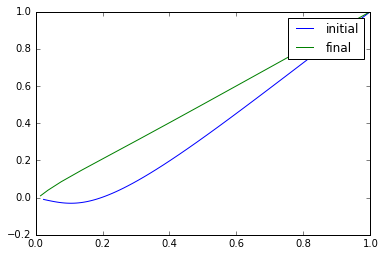

In [8]:
initial = env.plot(paths[0])
final = env.plot(paths[-1])
plt.legend(['initial','final'])

## Testing code

In [77]:
from sandbox.haoran.model_trpo.code.deterministic_mlp_policy import DeterministicMLPPolicy
from sandbox.haoran.model_trpo.code.hopper_env import HopperEnv
env = HopperEnv()
policy = DeterministicMLPPolicy(env,hidden_sizes=[32,32])

In [81]:
import lasagne.layers as L
params = L.get_all_param_values(policy.network.output_layer,trainable=True)
print [p.shape for p in params]

[(20, 32), (32,), (32, 32), (32,), (32, 3), (3,)]


In [83]:
import theano
theano.grad(policy.network.output_layer,policy.get_params(trainable=True))

AttributeError: 'DenseLayer' object has no attribute 'type'

> /Users/haoran/.local/lib/python2.7/site-packages/theano/gradient.py(430)grad()
    428             raise AssertionError("cost and known_grads can't both be None.")
    429 
--> 430     if cost is not None and isinstance(cost.type, NullType):
    431         raise ValueError("Can't differentiate a NaN cost."
    432                          "cost is NaN because " +

ipdb> q
